# MixedML on Python

In [1]:
from sys import path

path.append("../")

import seaborn as sns
from matplotlib.pyplot import subplots
from pandas import DataFrame
import pandas as pd
from reservoirpy import verbosity
from reservoirpy.nodes import Reservoir, Ridge
from sklearn.metrics import mean_squared_error as mse
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import RobustScaler


from training_utils.data import get_dataframe, remove_warmup_1D
from training_utils.global_config import N_WARMUPS
from mixed_ml import MixedMLEstimator

pd.options.display.float_format = "{:.3e}".format
verbosity(0)

0

In [2]:
data = get_dataframe("../../../data/synthetic_bph_1/01_test.csv")
SERIES = "individus"
TSTEPS = "temps"
#
data_train = data[data[SERIES] > 10]
data_test = data[data[SERIES] <= 10]

## Building the model 

Standard models can be used:

In [3]:
model_mlp = MLPRegressor((20, 10, 5), learning_rate="adaptive", max_iter=1000)
mixed_ml_mlp = MixedMLEstimator(model_mlp, recurrent_model=False)

Also recurrent ones:

In [4]:
model_rpy = Reservoir(units=50) >> Ridge(ridge=1e-1)
mixed_ml_rpy = MixedMLEstimator(model_rpy, recurrent_model=True)

## Training  
with simple features: x2_x5, x4_x7, x6_x8

In [5]:
X_LABELS = ["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8"]
Y_LABEL = "y_mixed_obs"
Y_LABELS_PRED = ["y_mixed", "y_mixed_obs"]

scaler_x = RobustScaler()
scaler_y = RobustScaler()

data_train_scaled = data_train[[SERIES, TSTEPS]].copy()
data_train_scaled[X_LABELS] = scaler_x.fit_transform(data_train[X_LABELS])
data_train_scaled[[Y_LABEL]] = scaler_y.fit_transform(data_train[[Y_LABEL]])

data_test_scaled = data_test[[SERIES, TSTEPS]].copy()
data_test_scaled[X_LABELS] = scaler_x.transform(data_test[X_LABELS])
data_test_scaled[[Y_LABEL]] = scaler_y.transform(data_test[[Y_LABEL]])

In [6]:
results_mlp = mixed_ml_mlp.fit(
    data_train_scaled, n_iter_improve=2, min_ratio_improve=0.01
)

mixedML step #00: 1.046574e-02 (best)
mixedML step #01: 1.085644e-02
mixedML step #02: 5.937083e-03 (best)
mixedML step #03: 5.572427e-03 (best)
mixedML step #04: 4.669442e-03 (best)
mixedML step #05: 4.272981e-03 (best)
mixedML step #06: 3.926353e-03 (best)
mixedML step #07: 3.714102e-03 (best)
mixedML step #08: 3.903811e-03
mixedML step #09: 3.889078e-03
mixedML step #10: 3.622999e-03 (best)
mixedML step #11: 3.404651e-03 (best)
mixedML step #12: 3.662323e-03
mixedML step #13: 3.300808e-03 (best)
mixedML step #14: 3.308557e-03
mixedML step #15: 3.141638e-03 (best)
mixedML step #16: 3.364063e-03
mixedML step #17: 3.368094e-03
mixedML step #18: 3.269270e-03


In [7]:
results_rpy = mixed_ml_rpy.fit(
    data_train_scaled,
    n_iter_improve=2,
    min_ratio_improve=0.01,
    fixed_model_options={"warmup": N_WARMUPS},
)

mixedML step #00: 3.846197e-02 (best)
mixedML step #01: 2.374416e-02 (best)
mixedML step #02: 1.865859e-02 (best)
mixedML step #03: 1.550584e-02 (best)
mixedML step #04: 1.323419e-02 (best)
mixedML step #05: 1.150551e-02 (best)
mixedML step #06: 1.015272e-02 (best)
mixedML step #07: 9.074655e-03 (best)
mixedML step #08: 8.203555e-03 (best)
mixedML step #09: 7.491478e-03 (best)
mixedML step #10: 6.903392e-03 (best)
mixedML step #11: 6.413147e-03 (best)
mixedML step #12: 6.000929e-03 (best)
mixedML step #13: 5.651537e-03 (best)
mixedML step #14: 5.353189e-03 (best)
mixedML step #15: 5.096668e-03 (best)
mixedML step #16: 4.874702e-03 (best)
mixedML step #17: 4.681503e-03 (best)
mixedML step #18: 4.512430e-03 (best)
mixedML step #19: 4.363732e-03 (best)
mixedML step #20: 4.232354e-03 (best)
mixedML step #21: 4.115791e-03 (best)
mixedML step #22: 4.011974e-03 (best)
mixedML step #23: 3.919183e-03 (best)
mixedML step #24: 3.835977e-03 (best)
mixedML step #25: 3.761145e-03 (best)
mixedML step

In [8]:
def plot_convergence(results_mlp, results_rpy):
    fig, ax = subplots()
    ax.plot(results_mlp, label="MLP")
    ax.plot(results_rpy, label="Reservoir")
    ax.legend(loc="center right", fontsize="x-large")
    ax.set_yscale("log")
    ax.set_title("Convergence")
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Model residuals (on scaled values)")
    _ = 0

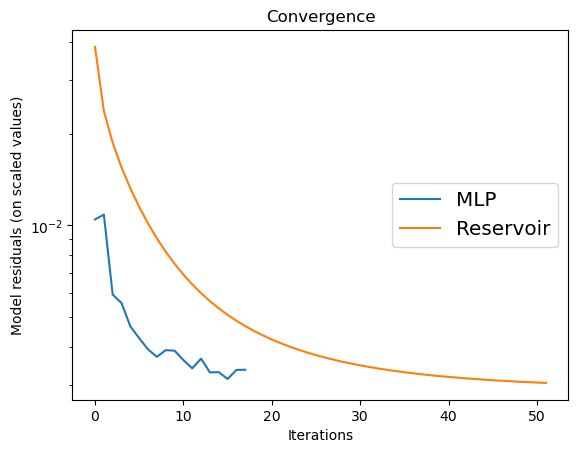

In [9]:
plot_convergence(results_mlp, results_rpy)

# Predictions

In [10]:
def get_predictions(mixed_ml_mlp, mixed_ml_rpy):
    lres = []
    for name, model in {"MLP": mixed_ml_mlp, "Reservoir": mixed_ml_rpy}.items():
        for subspec in [True, False]:
            for tgt_name in Y_LABELS_PRED:
                y_pred_scaled = model.predict(
                    data_test_scaled, use_subject_specific=subspec
                )
                y_pred_scaled = y_pred_scaled.reshape((len(y_pred_scaled), 1))
                y_pred = scaler_y.inverse_transform(y_pred_scaled)
                lres.append(
                    {
                        "model": name,
                        "ss": subspec,
                        "tgt_name": tgt_name,
                        "mse": mse(
                            remove_warmup_1D(data_test[tgt_name], N_WARMUPS),
                            remove_warmup_1D(y_pred, N_WARMUPS),
                        ),
                    }
                )
    return DataFrame(lres)

In [11]:
get_predictions(mixed_ml_mlp, mixed_ml_rpy)

,model,ss,tgt_name,mse
0,MLP,True,y_mixed,3.196e-01
1,MLP,True,y_mixed_obs,1.219e+00
2,MLP,False,y_mixed,7.281e+01
3,MLP,False,y_mixed_obs,7.296e+01
4,Reservoir,True,y_mixed,1.873e-01
5,Reservoir,True,y_mixed_obs,1.057e+00
6,Reservoir,False,y_mixed,1.697e+02
7,Reservoir,False,y_mixed_obs,1.722e+02
